# Import

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential

/home/kumakura/anaconda3/envs/test1/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import logging
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  2
2.8.0


# Function

In [4]:
def plot_hist(hist):
    fig = plt.figure(figsize=(16,8))
    
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    
    ax1.plot(hist.history["accuracy"])
    ax1.plot(hist.history["val_accuracy"])
    ax1.set_title("model accuracy")
    ax1.set_ylabel("accuracy")
    ax1.set_xlabel("epoch")
    
    ax2.plot(hist.history["loss"])
    ax2.plot(hist.history["val_loss"])
    ax2.set_title("model_loss")
    ax2.set_ylabel("loss")
    ax2.set_xlabel("epoch")
    fig.legend(["train", "validation"], loc="upper left")
    fig.show()

# Set values

In [5]:
tfds_name = 'stanford_dogs'
path_save = './'
img_size = 456
batch_size = 64

# Build classification model

In [6]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [7]:
strategy = tf.distribute.MirroredStrategy()

def build_efficient(num_classes):
    with strategy.scope():
    
        # Image augmentation
        input = layers.Input(shape=(img_size,img_size,3))
        x = img_augmentation(input)
    
        #Base pretrained model
        base_model = EfficientNetB5(input_shape=(img_size, img_size,3) ,include_top=False, weights="imagenet")
        base_model.trainable = False
        x = base_model(x)
    
        # Rebuild top
        top_dropout_rate = 0.2
        x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
        output = layers.Dense(num_classes, activation="softmax", name="pred")(x)
        
        model = Model(inputs=input,outputs=output)
        # Compile
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
        model.compile(
            optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        )
    
    return model

# Create tensorflow dataset

In [8]:
ds_train,info = tfds.load(tfds_name,split='train',shuffle_files=True,as_supervised=True,with_info=True)
ds_val = tfds.load(tfds_name,split='test',shuffle_files=True,as_supervised=True)

def load_and_preprocess_from_path_label(image, label):
  return tf.image.resize(image,[img_size,img_size]), tf.one_hot(label,info.features['label'].num_classes )

ds_train = ds_train.map(load_and_preprocess_from_path_label)
ds_val = ds_val.map(load_and_preprocess_from_path_label)

In [9]:
ds_batch_train = ds_train.batch(batch_size=batch_size, drop_remainder=False)
ds_batch_train = ds_batch_train.prefetch(tf.data.AUTOTUNE)
ds_batch_val = ds_val.batch(batch_size=batch_size, drop_remainder=False)

# Training and result

In [10]:
model = build_efficient(num_classes=info.features['label'].num_classes)

In [11]:
epochs = 6
hist = model.fit(ds_batch_train, epochs=epochs, validation_data=ds_batch_val,batch_size=batch_size, shuffle=True, verbose=1)

Epoch 1/6
188/188 [==============================] - 247s 1s/step - loss: 3.5502 - accuracy: 0.5771 - val_loss: 0.4944 - val_accuracy: 0.8605
Epoch 2/6
188/188 [==============================] - 220s 1s/step - loss: 1.5982 - accuracy: 0.7039 - val_loss: 0.3456 - val_accuracy: 0.9012
Epoch 3/6
188/188 [==============================] - 223s 1s/step - loss: 0.9569 - accuracy: 0.7589 - val_loss: 0.3082 - val_accuracy: 0.9122
Epoch 4/6
188/188 [==============================] - 223s 1s/step - loss: 0.7908 - accuracy: 0.7814 - val_loss: 0.3012 - val_accuracy: 0.9121
Epoch 5/6
188/188 [==============================] - 223s 1s/step - loss: 0.7398 - accuracy: 0.7878 - val_loss: 0.2987 - val_accuracy: 0.9153
Epoch 6/6
188/188 [==============================] - 223s 1s/step - loss: 0.7196 - accuracy: 0.7943 - val_loss: 0.3098 - val_accuracy: 0.9127


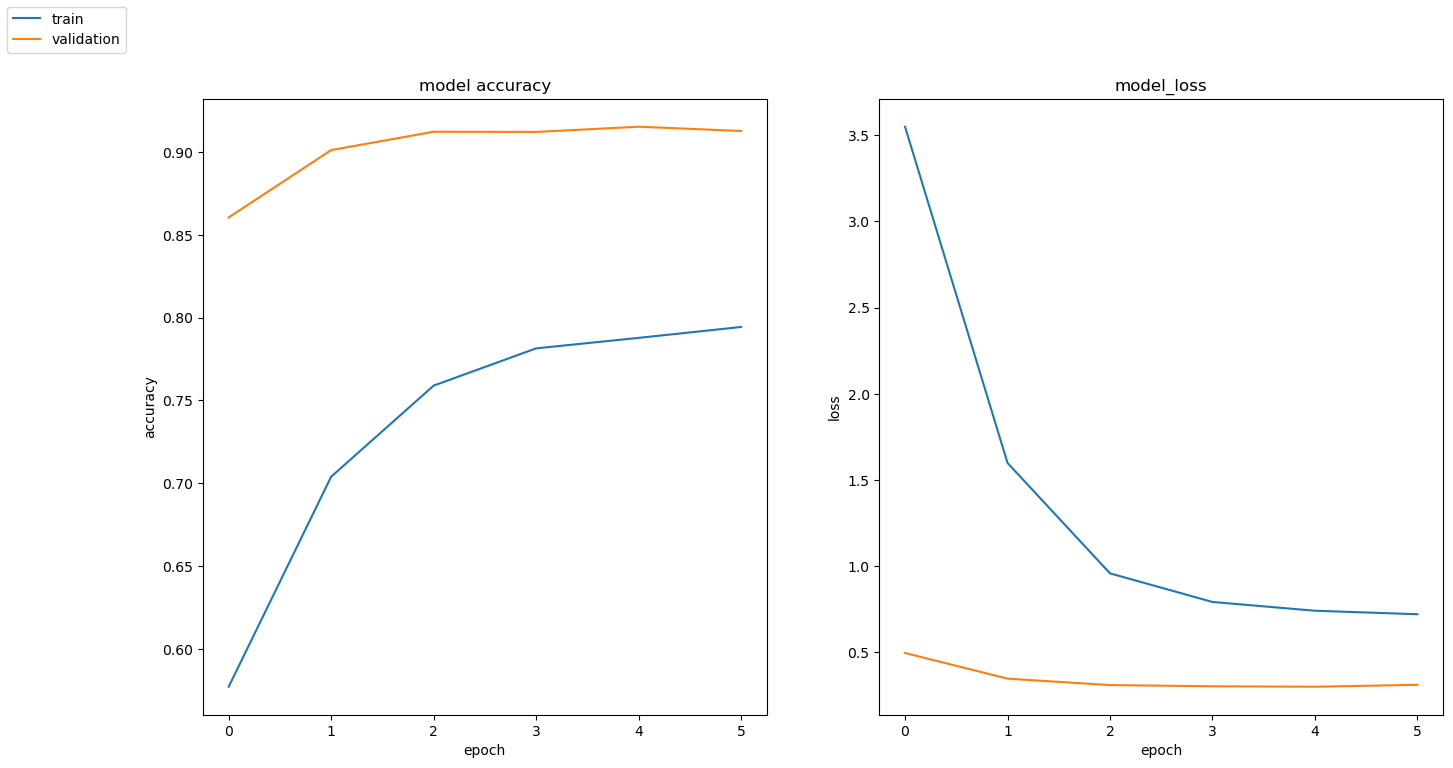

In [12]:
plot_hist(hist)

# Save

In [13]:
model.save(path_save+tfds_name+'_pretrained_model.h5')